In [1]:
# install stuff if running on Colab
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/Loop3D/map2model_cpp.git
    !pip install git+https://github.com/Loop3D/map2loop.git@structural-data-sampling
    !pip install git+https://github.com/Loop3D/LoopStructural.git@v1.5.11
    !pip install git+https://github.com/Loop3D/LoopProjectFile.git@0.0.26
    !pip install lavavu-osmesa==1.8.60
    !pip install meshio
    # data files in link below
    !gdown --folder https://drive.google.com/drive/folders/1fq7RmtlEsHTe3VUwj917MoK7LV4NPcIv
else:
      print('Not running on CoLab, nothing to do')

  Cloning https://github.com/Loop3D/map2model_cpp.git to /tmp/pip-req-build-z50zqmjw
  Running command git clone --filter=blob:none --quiet https://github.com/Loop3D/map2model_cpp.git /tmp/pip-req-build-z50zqmjw
  Resolved https://github.com/Loop3D/map2model_cpp.git to commit 4a3e59528e99a0592bd5cc213ee0eaae559b9c8a
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for map2model: filename=map2model-1.2.0-cp310-cp310-linux_x86_64.whl size=4840723 sha256=f51e246cb77c4abc118ea65bbc851bc94b14c8a2040828efc5e8ac05c22e0559
  Stored in directory: /tmp/pip-ephem-wheel-cache-261la7uw/wheels/8e/be/f7/b722f54fd3a176ede7c9b6ddd5f939abc9e16727b997f903e9
Successfully built map2model
  Cloning https://github.com/Loop3D/map2loop.git (to revision structural-data-sampling) to /tmp/pip-req-build-7ak4xytr
  Running command git clone --filter=blob:none --quiet https://github.com/Loop3D/map2loop.git /tmp/pip-req-build-7ak4xytr
  Running comm

In [2]:
import os
import time
import numpy as np
from osgeo import gdal
import pandas as pd
from datetime import datetime

from map2loop.project import Project
from map2loop.m2l_enums import VerboseLevel

from map2loop.m2l_enums import Datatype
from map2loop.sampler import SamplerSpacing, SamplerDecimator

import LoopStructural
import LoopProjectFile as LPF
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer
from LoopStructural.modelling.input.project_file import LoopProjectfileProcessor as LPFProcessor

In [3]:
nowtime=datetime.now().isoformat(timespec='minutes')
model_name=nowtime.replace(":","-").replace("T","-")
loop_project_filename = os.path.join(model_name, "local_source.loop3d")

In [4]:
bounding_box = {
    "minx": 0,
    "miny": 0,
    "maxx": 10000,
    "maxy": 10000,
    "base": 0,
    "top": -5000,
}

In [5]:
proj = Project(
    geology_filename = "./m2l3_inputs/lithologies.shp",
    fault_filename = "./m2l3_inputs/faults.shp",
    fold_filename = "./m2l3_inputs/faults.shp",
    structure_filename = "./m2l3_inputs/structures_v3.shp",
    dtm_filename = './m2l3_inputs/DEM.tif',
    config_filename = './m2l3_inputs/example.hjson',
    clut_filename = './m2l3_inputs/500kibg_colours.csv',
    clut_file_legacy = True,
    verbose_level = VerboseLevel.NONE,
    tmp_path = model_name,
    working_projection = "EPSG:7854",
    bounding_box = bounding_box,
    loop_project_filename = loop_project_filename
)

Unused keys from legacy format ['msc', 'msn', 'mst', 'mtc', 'mscm', 'mcom', 'minf', 'fdipdir_flag', 'deposit_dist']


In [6]:
proj.set_sampler(Datatype.STRUCTURE, SamplerDecimator(1))

In [7]:
# Or you can run map2loop and pre-specify the stratigraphic column
column = [
    # youngest
    'Litho_K',
    'Litho_J',
    'Litho_I',
    'Litho_H',
    'Litho_G',
    'Litho_F',
    'Litho_E',
    'Litho_D',
    'Litho_C',
    'Litho_B',
    'Litho_A',
    # oldest
]

proj.run_all(user_defined_stratigraphic_column=column)

Cannot calculate thickness between Litho_B and Litho_A


In [8]:
LPFilename = loop_project_filename
projFile = LPF.ProjectFile(LPFilename)
processedData = LPFProcessor(projFile)

In [9]:
# check thicknesses
processedData.thicknesses

{'Litho_K': 602.4146812917289,
 'Litho_J': 574.2872558733877,
 'Litho_I': 656.5879056017706,
 'Litho_H': 609.979376746783,
 'Litho_G': 566.9844610139112,
 'Litho_F': 526.1135353050323,
 'Litho_E': 602.4343336237904,
 'Litho_D': 606.7571007560082,
 'Litho_C': 676.173481413148,
 'Litho_B': 602.4146812917289,
 'Litho_A': 602.4146812917289}

In [10]:
foliation_params = {
    'interpolatortype':'FDI' , # 'interpolatortype':'PLI',
    'nelements':1e4,  # how many tetras/voxels
    'regularisation':5,
    'solver': 'pyamg'
}


In [11]:
model = LoopStructural.GeologicalModel.from_processor(processedData)
model.update()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]


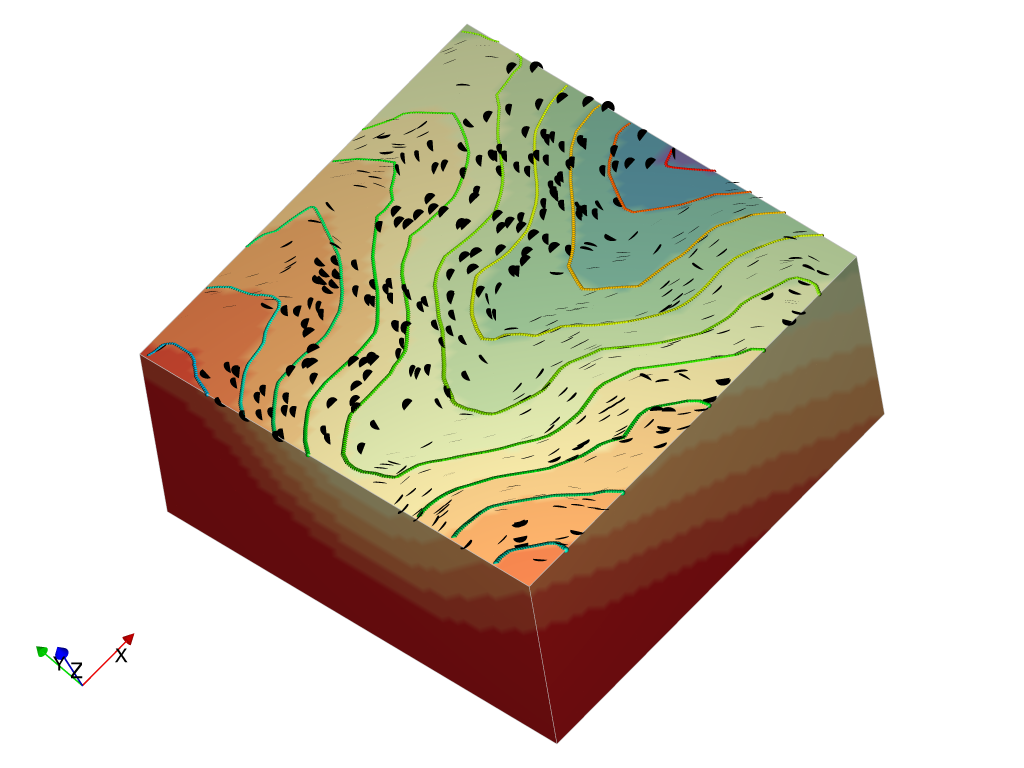

In [13]:
view = LavaVuModelViewer(model)

view.add_data(model['sg'])
view.add_model()
view.add_model_surfaces()

view.rotation = [-30.66925048828125, 24.756322860717773, 45.22917175292969]
view.display()